## Implementation of the AdaBoost Algorithm

In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from tqdm import tqdm

X shape: (2, 160) Y shape: (1, 160)


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 65.55it/s]


Accuracy: 74.375 %


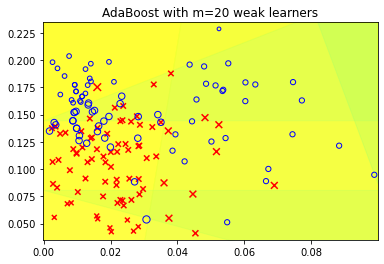

100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 66.59it/s]


Accuracy: 74.375 %


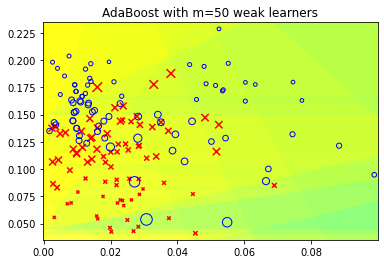

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 66.86it/s]


Accuracy: 75.625 %


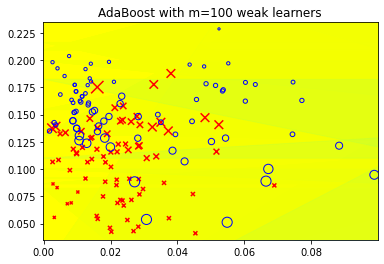

100%|█████████████████████████████████████████| 500/500 [00:07<00:00, 67.14it/s]


Accuracy: 81.25 %


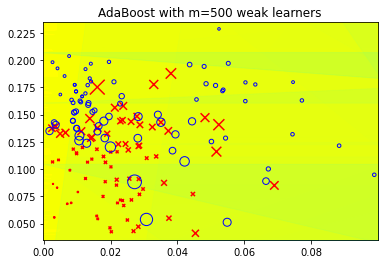

100%|███████████████████████████████████████| 1000/1000 [00:14<00:00, 67.85it/s]


Accuracy: 81.25 %


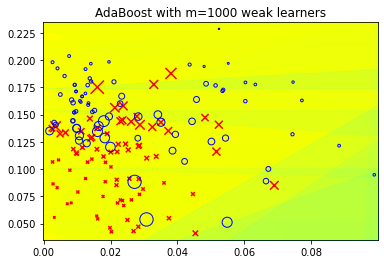

In [2]:
trX = loadmat('data/trX.mat')
trY = loadmat('data/trY.mat')

X = trX['trX']
Y = trY['trY']
print("X shape:",X.shape,"Y shape:",Y.shape)

def tanh(X):
    return np.tanh(X)

def tanh_prime(X):
    return 1 - (tanh(X))**2

def perceptron_train(X,y,wt):
    
    # Adding Bias
    X = np.insert(X,X.shape[0],np.ones(X.shape[1]),axis=0)
    
    # Initialize perceptron weights, learning rate, iterations
    W = np.random.normal(size = (1,X.shape[0]))
    lr = 0.001
    itr = 1000

    for i in range(itr):
        y_hat = tanh(np.dot(W,X))
        grad_w = np.dot(-1 * wt * tanh_prime(y_hat) * (y-y_hat),X.T)
        W = W - lr * grad_w
        
    y_hat = tanh(np.dot(W,X))
    
    return y_hat,W

def adaboost_perceptron(X,y,m_learners):
    
    # number of samples
    n = X.shape[1]
    
    # Initializing weights as 1/n for all samples
    wt = (np.ones(n)/n).reshape(1,-1)
    
    # Save the predictions of m learners
    y_preds_m  = np.zeros(y.shape)
    perceptron_weights = np.zeros((m_learners,X.shape[0]+1))
    final_pred_m = np.zeros((m_learners,y.shape[1]))
    for m in tqdm(range(m_learners)):
        # Train mth perceptron
        y_hat,W = perceptron_train(X,y,wt)
        y_hat = np.sign(y_hat)
        perceptron_weights[m]=W
            
        # Find beta value
        ind_eq = np.sum(np.array([wt[:,i] for i in range(wt.shape[1]) if y[:,i]==y_hat[:,i]]))
        ind_neq = np.sum(np.array([wt[:,i] for i in range(wt.shape[1]) if y[:,i]!=y_hat[:,i]]))
        beta_m = (0.5)*np.log(ind_eq/ind_neq)
        
        # Update sample weights
        wt = wt * np.exp(-1 * beta_m * y * y_hat)
        wt = wt / np.sum(wt)
        
        # Weighted sum of learners
        y_preds_m = y_preds_m + beta_m * y_hat
        final_pred_m[m] = beta_m * y_hat
        
    y_hat = np.sign(y_preds_m)
    
    return y_hat, wt, perceptron_weights, final_pred_m

# To make plots that show the final weights over the examples (by changing the size of the markers), as well as the prediction of the models (giving different colors to the area).

for i in [20,50,100,500,1000]:
    y_hat,wt,perceptron_weights,final_preds_m = adaboost_perceptron(X,Y,i)
    acc = (np.sum(np.round(y_hat[0])==Y[0])/160)*100
    print("Accuracy:",acc,"%")
    
    for m in range(i):
        x = np.linspace(0, 0.1, 100)
        y = (-(perceptron_weights[m,2] / perceptron_weights[m,1]) / (perceptron_weights[m,2]
                                                                         / perceptron_weights[m,0])) * x + (-perceptron_weights[m,2] / perceptron_weights[m,1])
        plt.fill_between(x, y,X[1].max() + 6e-3, alpha=0.1, color='yellow')
        plt.fill_betweenx(y, x, X[0].max() + 2e-3, alpha=0.1, color='aqua')

    idx = np.squeeze([Y == -1])
    x = X[:, idx][0]
    y = X[:, idx][1]
    s = ((wt[-1] / wt[-1].sum()) * 5000)[idx]
    plt.scatter(x, y, marker='x', color='red', s=s)

    idx = np.squeeze([Y == 1])
    x = X[:, idx][0]
    y = X[:, idx][1]
    s = ((wt[-1] / wt[-1].sum()) * 5000)[idx]
    plt.scatter(x, y, marker='o', color='blue', s=s, facecolor='none')

    plt.ylim(bottom=X[1,:].min() - 6e-3, top=X[1,:].max() + 6e-3)
    plt.xlim(left=X[0,:].min() - 2e-3, right=X[0,:].max() + 1e-3)

    plt.title("AdaBoost with m=%i weak learners"%i)
    plt.show()